 # Time Series Partition, Naive Forecast, Forecast Accuracy and Residuals.

### Import required packages.

In [84]:
from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from dmba import regressionSummary
import warnings

import matplotlib.pylab as plt
%matplotlib inline


### Create templates for graph layout.

In [85]:
# Create a template for graph layout with partitions for data set. 
def Graph_Layout_Partition_Data():
    # Determine coordinates for drawing vertical lines and 
    # horizontal arrows on the chart.    
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
    xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
    xfuture = (max(valid_ts.index) + one_month, '2022')
    xtv = xtrain[1] + 0.7 * (xvalid[0] - xtrain[1])
    xvf = xvalid[1] + 1.0 * (xfuture[0] - xvalid[1])

    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2013-12', 3300), xytext=('1991', 3300), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2018-12', 3300), xytext=('2014-2', 3300), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2021-12', 3300), xytext=('2019-2', 3300), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('2001', 3330, 'Training')
    ax.text('2015-1', 3330, 'Validation')
    ax.text('2019-7', 3330, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2022')
    ax.set_ylim(1300, 3500)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')
    
# Create a template for graph layout with partitions for residuals. 
def Graph_Layout_Partition_Residuals():
    # Determine coordinates for drawing vertical lines and 
    # horizontal arrows on the chart.    
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
    xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
    xfuture = (max(valid_ts.index) + one_month, '2022')
    xtv = xtrain[1] + 0.7 * (xvalid[0] - xtrain[1])
    xvf = xvalid[1] + 1.0 * (xfuture[0] - xvalid[1])

    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2013-12', 600), xytext=('1991', 600), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2018-12', 600), xytext=('2014-2', 600), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2021-12', 600), xytext=('2019-2', 600), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('2001', 620, 'Training')
    ax.text('2015-1', 620, 'Validation')
    ax.text('2019-7', 620, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2022')
    ax.set_ylim(-600, 700)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')


# Create a template for graph layout with entire dataset and 12 periods 
# in future. 
def Graph_Layout_Entire_Data():
    # Determine coordinates for drawing vertical lines and horizontal 
    # arrows on the chart.
    one_month = pd.Timedelta('31 days')
    xridership = (min(ridership_ts.index), max(ridership_ts.index) - one_month)
    xfuture = (max(ridership_ts.index) + one_month, '2022')
    xvf = xridership[1] + 0.7 * (xfuture[0] - xridership[1])

    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2018-12', 3300), xytext=('1991', 3300), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2021-12', 3300), xytext=('2019-2', 3300), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('2005', 3330, 'Training')
    ax.text('2019-7', 3330, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2022')
    ax.set_ylim(1300, 3500)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')

### Create measures of forecast accuracy.

In [86]:
# Create forcast accuracy measures.
def Forecast_Accuracy(actual, forecast):
    
    # ME - mean error.
    me = round(np.mean(actual - forecast),3) 
    
    # RMSE - root mean square error (RMSE)
    rmse = round((np.mean((actual - forecast)**2)**.5),3)  
   
    # MAE - mean absolute error.
    mae = round(np.mean(np.abs(actual - forecast)),3)   
   
    # MPE - mean percentage error,%.
    mpe = round(((np.mean((actual - forecast)/actual))*100),3) 
    
    # MAPE - mean absolute percentage error, %.
    mape = round(((np.mean(np.abs((actual - forecast)/actual)))*100),3) 
    
    # Ignore unnecessary future warnings on ACF1. 
    warnings.filterwarnings('ignore')
    
    # ACF1 - autocorrelation of errors at lag 1.
    acf1 = round((acf(actual - forecast)[1]),3)                 
    
    return({'ME':me, 'RMSE':rmse, 'MAE':mae, 
            'MPE':mpe, 'MAPE':mape, 'ACF1':acf1})
 

### Create time series data set.

In [87]:
# Create Amtrak data frame.
Amtrak_data = pd.read_csv('Amtrak_comp.csv')

# Display the first 5 records of Amtrak data set.

# Convert the date information to a datetime object as monthly data.
Amtrak_data['Date'] = pd.to_datetime(Amtrak_data.Month)

# Convert data set to time series  data set. Name is used 
# to label the data.
ridership_ts = pd.Series(Amtrak_data.Ridership.values, 
                index=Amtrak_data.Date, name='Ridership')

# Define Amtrak time series frequency as month 'MS'. 
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq = 'MS')

# Display first 5 records of Amtrak time series data.
ridership_ts.head()
ridership_ts.tail()

Date
2018-08-01    2848.935
2018-09-01    2522.367
2018-10-01    2807.200
2018-11-01    2873.968
2018-12-01    2668.049
Freq: MS, Name: Ridership, dtype: float64

### Create data partition and plot data partition. 

In [88]:
# Create a time series with additional linear trend index for 
# entire data set. 
# This will enable to develop training and validation forecasts 
# and plot them.
ridership_df = tsatools.add_trend(ridership_ts, trend='t')

# Display Amtrak Ridership data set.
print(ridership_df)

# Define the numbers of months in the training and validation sets,
# nTrain and nValid, respectively.
nValid = 60
nTrain = len(ridership_df) - nValid

# Partition the training data set and display it. 
train_ts = ridership_df[:nTrain]
print()
print('Training Data Set')
print(train_ts)

# Partition the validation data set and show (print) it. 
valid_ts = ridership_df[nTrain:]
print()
print('Validation Data Set')
print(valid_ts.head())
print(valid_ts.tail())


            Ridership  trend
Date                        
1991-01-01   1708.917    1.0
1991-02-01   1620.586    2.0
1991-03-01   1972.715    3.0
1991-04-01   1811.665    4.0
1991-05-01   1974.964    5.0
...               ...    ...
2018-08-01   2848.935  332.0
2018-09-01   2522.367  333.0
2018-10-01   2807.200  334.0
2018-11-01   2873.968  335.0
2018-12-01   2668.049  336.0

[336 rows x 2 columns]

Training Data Set
            Ridership  trend
Date                        
1991-01-01   1708.917    1.0
1991-02-01   1620.586    2.0
1991-03-01   1972.715    3.0
1991-04-01   1811.665    4.0
1991-05-01   1974.964    5.0
...               ...    ...
2013-08-01   2851.979  272.0
2013-09-01   2440.153  273.0
2013-10-01   2625.820  274.0
2013-11-01   2550.704  275.0
2013-12-01   2711.851  276.0

[276 rows x 2 columns]

Validation Data Set
            Ridership  trend
Date                        
2014-01-01   2206.788  277.0
2014-02-01   2092.819  278.0
2014-03-01   2575.951  279.0
2014-04-01   

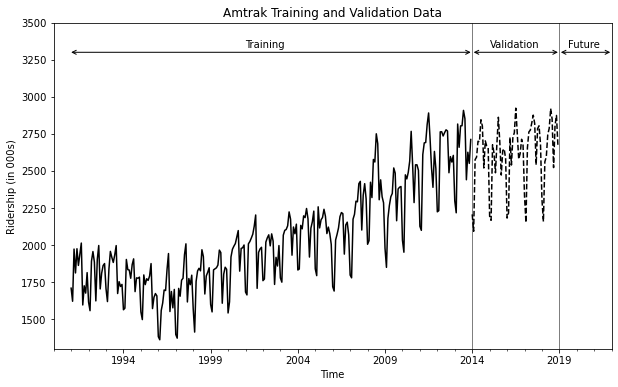

In [89]:
# Plot partitioned data. 

# Plot training data set.
ax = train_ts.plot(color='black', linewidth=1.5, figsize=(10,6))

# Plot valiation data set.
valid_ts.plot(ax = ax, color='black', linestyle='dashed', linewidth=1.5)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph legend and title.
plt.title('Amtrak Training and Validation Data')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

### Fit regression models for training data. Forecast using validation set. Plot forecasts. 

In [90]:
# Fit a linear regression model to time series with linear trend.
ridership_lin = sm.ols(formula='Ridership ~ trend', 
                       data=train_ts).fit()

# Fit a linear regression model to time series with quadratic trend.
ridership_quad = sm.ols(formula='Ridership ~ trend + np.square(trend)', 
                       data=train_ts).fit()

# See (print) summary of forecasting equation and associated parameters. 
print('Linear Regression Parameters')
print(ridership_lin.summary())
print(' ')
print('Quadratic Regression Parameters')
print(ridership_quad.summary())

Linear Regression Parameters
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     544.1
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           4.87e-67
Time:                        22:16:12   Log-Likelihood:                -1854.5
No. Observations:                 276   AIC:                             3713.
Df Residuals:                     274   BIC:                             3720.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1552.7413  

In [91]:
# Apply forecast to make predictions in training and validation sets.
ridership_lin_pred = ridership_lin.predict(valid_ts)
ridership_quad_pred = ridership_quad.predict(valid_ts)

# Display forecast for linear trend. 
print('Linear Trend forecast for Validation Set')
print(ridership_lin_pred.head())
print(ridership_lin_pred.tail())

# Display forecast for quadratic trend.
print(' ')
print('Quadratic Trend Forecast for Validation Set')
print(ridership_quad_pred.head())
print(ridership_quad_pred.tail())



Linear Trend forecast for Validation Set
Date
2014-01-01    2534.333060
2014-02-01    2537.876713
2014-03-01    2541.420365
2014-04-01    2544.964018
2014-05-01    2548.507670
dtype: float64
Date
2018-08-01    2729.233945
2018-09-01    2732.777598
2018-10-01    2736.321250
2018-11-01    2739.864902
2018-12-01    2743.408555
dtype: float64
 
Quadratic Trend Forecast for Validation Set
Date
2014-01-01    2757.770644
2014-02-01    2766.154100
2014-03-01    2774.572374
2014-04-01    2783.025467
2014-05-01    2791.513379
dtype: float64
Date
2018-08-01    3270.566519
2018-09-01    3280.865005
2018-10-01    3291.198310
2018-11-01    3301.566433
2018-12-01    3311.969375
dtype: float64


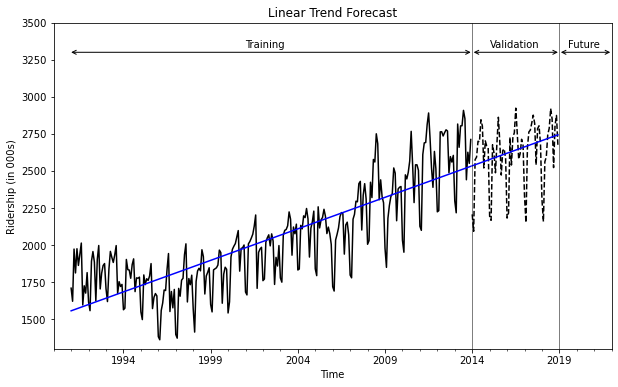

In [92]:
# Plot predictions for linear trend forecast. 

# Plot training and validation sets.
ax = train_ts.plot(color='black', linewidth=1.5, figsize=(10,6))
valid_ts.plot(ax=ax, color='black', linestyle='dashed', 
              linewidth=1.5)

# Plot linear trend forecast for training set. 
ridership_lin_pred_train = ridership_lin.predict(train_ts)
ridership_lin_pred_train.plot(ax = ax, color = 'blue')

# Plot linear trend forecast for validation set.
ridership_lin_pred.plot(ax = ax, color = 'blue')

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph title.
plt.title('Linear Trend Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

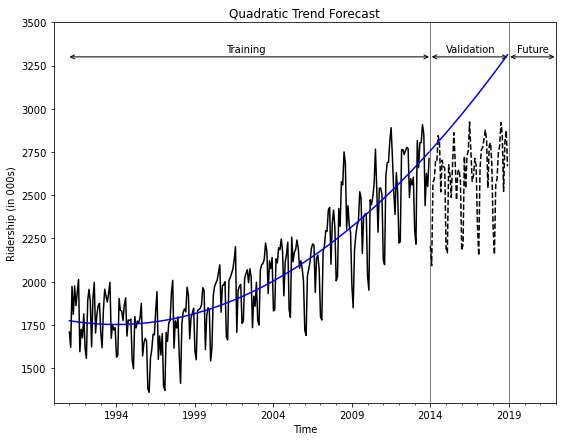

In [93]:
# Plot predictions for quadratic trend forecast. 

# Plot training and validation sets.
ax = train_ts.plot(color = 'black', linewidth=1.5, figsize=(9,7))
valid_ts.plot(ax = ax, color = 'black', linestyle='dashed', linewidth=1.5)

# Plot quadratic trend forecast for training set. 
ridership_quad_pred_train = ridership_quad.predict(train_ts)
ridership_quad_pred_train.plot(ax = ax, color = 'blue')

# Plot quadratic trend forecast for validation set.
ridership_quad_pred.plot(ax = ax, color = 'blue')

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph title.
plt.title('Quadratic Trend Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

### Identify Forecast Accuracy. 

In [94]:
# Reformat train_ts dataframe to train_ts_ref to incorporate 
# valiation data set only without trend parameter "t".
train_ts_ref = ridership_ts[:nTrain]

# Reformat valid_ts dataframe to valid_ts_ref to incorporate 
# valiation data set only without trend parameter "t".
valid_ts_ref = ridership_ts[nTrain:]

# Use regressionSummary() to identfiy common accuracy measures 
# for linear trend in validation data set.
print('       Accuracy Measures for Linear Trend')
regressionSummary(valid_ts_ref, ridership_lin_pred)

# Use regressionSummary() to identfiy common accuracy measures 
# for quadratic trend in validation data set.
print(' ')
print('       Accuracy Measures for Quadratic Trend')
regressionSummary(valid_ts_ref, ridership_quad_pred)


       Accuracy Measures for Linear Trend

Regression statistics

                      Mean Error (ME) : -22.3345
       Root Mean Squared Error (RMSE) : 208.7877
            Mean Absolute Error (MAE) : 159.3591
          Mean Percentage Error (MPE) : -1.5526
Mean Absolute Percentage Error (MAPE) : 6.4719
 
       Accuracy Measures for Quadratic Trend

Regression statistics

                      Mean Error (ME) : -408.4046
       Root Mean Squared Error (RMSE) : 470.3144
            Mean Absolute Error (MAE) : 409.6164
          Mean Percentage Error (MPE) : -16.3296
Mean Absolute Percentage Error (MAPE) : 16.3722


In [95]:
# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy 
# measures for linear trend in validation data set.
print('Accuracy Measures for Linear Trend')
print(Forecast_Accuracy(valid_ts_ref, ridership_lin_pred))

# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy 
# measures for quadratic trend in validation data set.
print(' ')
print('Accuracy Measures for Quadratic Trend')
print(Forecast_Accuracy(valid_ts_ref, ridership_quad_pred))
# import warnings
# warnings.filterwarnings('ignore')


Accuracy Measures for Linear Trend
{'ME': -22.335, 'RMSE': 208.788, 'MAE': 159.359, 'MPE': -1.553, 'MAPE': 6.472, 'ACF1': 0.431}
 
Accuracy Measures for Quadratic Trend
{'ME': -408.405, 'RMSE': 470.314, 'MAE': 409.616, 'MPE': -16.33, 'MAPE': 16.372, 'ACF1': 0.553}


### Identify Naive and Seasonal Naive Forecasts. 

In [96]:
# Generate naive forecast for training and validation data sets. 
# Take the previous value of train_ts_ref [:-1] and use it as naive 
# forecast for training data.
ridership_naive_pred_train = pd.Series(train_ts_ref[:-1].values, 
                        index=train_ts_ref[1:].index)
print('Naive Forecast for Training Data Set')
print(ridership_naive_pred_train)

# Take the last value of train_ts [-1] and use it as naive 
# forecast for validation valid_ts_ref data.
ridership_naive_pred = pd.Series(train_ts_ref[-1], 
                        index=valid_ts_ref.index)
print(' ')
print('Naive Forecast for Valiation Data Set')
print(ridership_naive_pred.head())
print(ridership_naive_pred.tail())




Naive Forecast for Training Data Set
Date
1991-02-01    1708.917
1991-03-01    1620.586
1991-04-01    1972.715
1991-05-01    1811.665
1991-06-01    1974.964
                ...   
2013-08-01    2908.190
2013-09-01    2851.979
2013-10-01    2440.153
2013-11-01    2625.820
2013-12-01    2550.704
Freq: MS, Length: 275, dtype: float64
 
Naive Forecast for Valiation Data Set
Date
2014-01-01    2711.851
2014-02-01    2711.851
2014-03-01    2711.851
2014-04-01    2711.851
2014-05-01    2711.851
Freq: MS, dtype: float64
Date
2018-08-01    2711.851
2018-09-01    2711.851
2018-10-01    2711.851
2018-11-01    2711.851
2018-12-01    2711.851
Freq: MS, dtype: float64


In [97]:
# Generate seasonal naive forecast for training and validation data sets. 
# Take 12 previous periods of train_ts_ref [:-12] and use it as seasonal 
# naive forecast for training data.
ridership_snaive_pred_train = pd.Series(train_ts_ref[:-12].values, 
                        index=train_ts_ref[12:].index)
print(' ')
print('Seasonal Naive Forecast for Training Data Set')
print(ridership_snaive_pred_train.head())
print(ridership_snaive_pred_train.tail())

# Generate the seasonal naive forecast for valiation data set.
# Last 12 periods of the training data set train_ts [-12:] to 
# be used for seasonal naive forecast.
last_season = train_ts_ref[-12:] 
print(' ')
print('Last 12 Months of Training Data Set')
# print(last_season)

# For naive seasonal forecast, multiple last_season, which is only 12 periods, 
# by the number of years (4) to ensure the seasonal naive forecast 
# for all validation periods. 
ridership_snaive_pred = pd.Series(pd.concat([last_season]*5)
                        [:len(valid_ts_ref)].values, index=valid_ts_ref.index)
print(" ")
print('Seasonal Naive Forecast for Valiation Data Set')
print(ridership_snaive_pred.head())
print(ridership_snaive_pred.tail())

 
Seasonal Naive Forecast for Training Data Set
Date
1992-01-01    1708.917
1992-02-01    1620.586
1992-03-01    1972.715
1992-04-01    1811.665
1992-05-01    1974.964
Freq: MS, dtype: float64
Date
2013-08-01    2769.229
2013-09-01    2487.441
2013-10-01    2596.272
2013-11-01    2559.615
2013-12-01    2604.566
Freq: MS, dtype: float64
 
Last 12 Months of Training Data Set
 
Seasonal Naive Forecast for Valiation Data Set
Date
2014-01-01    2298.047
2014-02-01    2217.348
2014-03-01    2816.139
2014-04-01    2659.243
2014-05-01    2803.527
Freq: MS, dtype: float64
Date
2018-08-01    2851.979
2018-09-01    2440.153
2018-10-01    2625.820
2018-11-01    2550.704
2018-12-01    2711.851
Freq: MS, dtype: float64


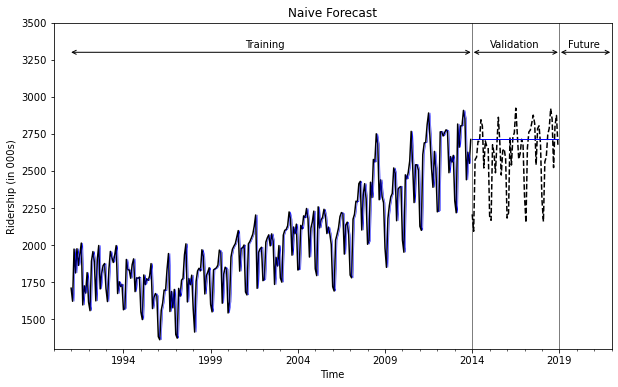

In [98]:
# Plot predictions for naive forecast. 

# Plot training and validation sets.
ax = train_ts.plot(color='black', linewidth=1.5, figsize=(10,6))
valid_ts.plot(ax=ax, color='black', linestyle='dashed', linewidth=1.5)

# Plot naive forecast for training and validation sets.
ridership_naive_pred_train.plot(ax = ax, color='blue', linewidth=0.5)
ridership_naive_pred.plot(ax = ax, color ='blue', linewidth=1.0)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph title.
plt.title('Naive Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

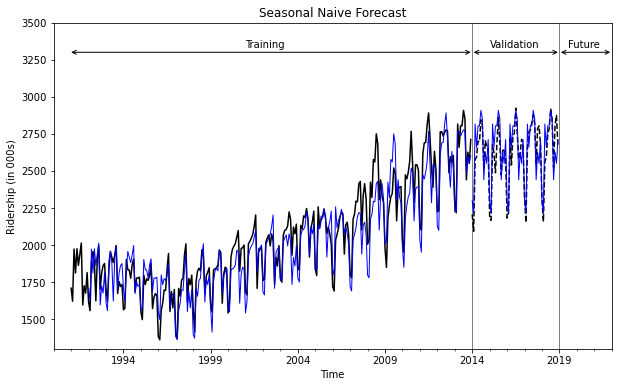

In [99]:
# Plot predictions for seasonal naive forecast. 

# Plot training and validation sets.
ax = train_ts.plot(color='black', linewidth=1.5, figsize=(10,6))
valid_ts.plot(ax=ax, color='black', linestyle='dashed', linewidth=1.5)

# Plot seasonal naive forecast for validation set.
ridership_snaive_pred_train.plot(ax = ax, color="blue", linewidth=1.0)
ridership_snaive_pred.plot(ax = ax, color="blue", linewidth=1.0)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph title.
plt.title('Seasonal Naive Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()

### Identify forecast accuracy for naive and seasonal naive forecasts. 

In [100]:
# Use regressionSummary() to identfiy common accuracy measures 
# for naive forecast in validation data set.
print('       Accuracy Measures for Naive Forecast')
regressionSummary(valid_ts_ref, ridership_naive_pred)

# Use regressionSummary() to identfiy common accuracy measures 
# for naive forecast in validation data set.
print(' ')
print('       Accuracy Measures for Seasonal Naive Forecast')
regressionSummary(valid_ts_ref, ridership_snaive_pred)

       Accuracy Measures for Naive Forecast

Regression statistics

                      Mean Error (ME) : -95.3147
       Root Mean Squared Error (RMSE) : 235.2198
            Mean Absolute Error (MAE) : 164.6755
          Mean Percentage Error (MPE) : -4.4162
Mean Absolute Percentage Error (MAPE) : 6.8565
 
       Accuracy Measures for Seasonal Naive Forecast

Regression statistics

                      Mean Error (ME) : -24.1069
       Root Mean Squared Error (RMSE) : 116.6733
            Mean Absolute Error (MAE) : 91.0141
          Mean Percentage Error (MPE) : -1.0311
Mean Absolute Percentage Error (MAPE) : 3.4975


In [101]:
# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy 
# measures for naive forecast in validation data set.
print('Accuracy Measures for Naive Forecast')
print(Forecast_Accuracy(valid_ts_ref, ridership_naive_pred))

# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy 
# measures for seasonal naive forecast in validation data set.
print(' ')
print('Accuracy Measures for Seasonal Naive Forecast')
print(Forecast_Accuracy(valid_ts_ref, ridership_snaive_pred))


Accuracy Measures for Naive Forecast
{'ME': -95.315, 'RMSE': 235.22, 'MAE': 164.676, 'MPE': -4.416, 'MAPE': 6.856, 'ACF1': 0.456}
 
Accuracy Measures for Seasonal Naive Forecast
{'ME': -24.107, 'RMSE': 116.673, 'MAE': 91.014, 'MPE': -1.031, 'MAPE': 3.497, 'ACF1': 0.344}


### Identify forecast errors for linear trend forecast. Plot forecast errors. Develop error histogram. 

In [102]:
# Use actual and forecasted values for training data set to 
# identify training errors (residuals).
ridership_train_res = train_ts.Ridership - ridership_lin_pred_train
print('Training Errors for Quadratic Trend Forecast')
print(ridership_train_res)

# Use actual and forecasted values for validation data set to 
# identify validation errors (residuals).
ridership_valid_res = valid_ts.Ridership - ridership_lin_pred
print(' ')
print('Validation Errors for Quadratic Trend Forecast')
print(ridership_valid_res.head())
print(ridership_valid_res.tail())

Training Errors for Quadratic Trend Forecast
Date
1991-01-01    152.632016
1991-02-01     60.757364
1991-03-01    409.342712
1991-04-01    244.749059
1991-05-01    404.504407
                 ...    
2013-08-01    335.364202
2013-09-01    -80.005450
2013-10-01    102.117897
2013-11-01     23.458245
2013-12-01    181.061592
Freq: MS, Length: 276, dtype: float64
 
Validation Errors for Quadratic Trend Forecast
Date
2014-01-01   -327.545060
2014-02-01   -445.057713
2014-03-01     34.530635
2014-04-01     48.029982
2014-05-01    151.671330
Freq: MS, dtype: float64
Date
2018-08-01    119.701055
2018-09-01   -210.410598
2018-10-01     70.878750
2018-11-01    134.103098
2018-12-01    -75.359555
Freq: MS, dtype: float64


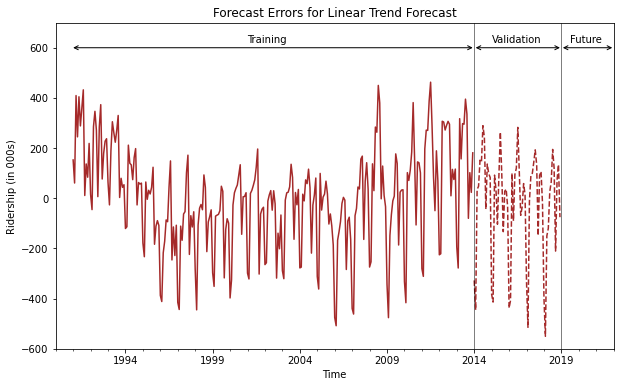

In [103]:
# Plot forecast errors for linear trend forecast. 
ax = ridership_train_res.plot(color='brown', linewidth=1.5, figsize=(10,6))
ridership_valid_res.plot(ax=ax, color='brown', linestyle='dashed', linewidth=1.5)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Residuals()

# Create graph title.
plt.title('Forecast Errors for Linear Trend Forecast')

# Set unnecessary legend invisible in the chart.  
ax.legend().set_visible(False)

plt.show()


1.0


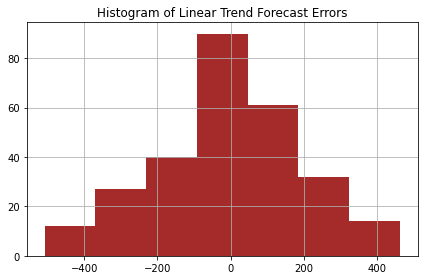

In [104]:
# Use hist() function to develop histogram for the model residuals. 

# Determine the percentage of datapoints with a residual in 
# (-600, 600).
print(len(ridership_train_res[(ridership_train_res > -600) 
             & (ridership_train_res < 600)]) / len(ridership_train_res))

ax = pd.DataFrame({'Histogram of Linear Trend Forecast Errors'
                   : ridership_train_res}).hist(bins=7, color = 'brown')

plt.tight_layout()

plt.show()
